In [1]:
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
print(sys.path)

['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython']
['/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages']


In [2]:
import loompy
import numpy as np
import pandas as pd
import scvelo as sv
import anndata
import scanpy as sc
import time
import skdim
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats

mpl.rcParams['figure.dpi'] = 70

from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize

from sklearn.neighbors import NearestNeighbors

import os
os.environ['R_HOME'] = '/usr/lib/R'
import rpy2.robjects as ro

def smooth_adata_by_pooling(adata,X_embed,n_neighbours=10):
    adata_pooled = adata.copy()
    nbrs = NearestNeighbors(n_neighbors=n_neighbours).fit(X_embed)
    distances, indices = nbrs.kneighbors(X_embed)    
    adata_pooled.X = smooth_matrix_by_pooling(get_nd_array(adata.X),indices)
    if 'matrix' in adata.layers:
        adata_pooled.layers['matrix'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['matrix']),indices)
    if 'spliced' in adata.layers:
        adata_pooled.layers['spliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['spliced']),indices)
    if 'unspliced' in adata.layers:
        adata_pooled.layers['unspliced'] = smooth_matrix_by_pooling(get_nd_array(adata.layers['unspliced']),indices)
    return adata_pooled

def smooth_matrix_by_pooling(matrix,indices):
    matrix_pooled = matrix.copy()
    for i in range(len(indices)):
        matrix_pooled[i,:] = np.mean(matrix[indices[i],:],axis=0)
    return matrix_pooled

def get_nd_array(arr):
    x = None
    if str(type(arr)):
        x = arr
    else:
        x = arr.toarray()
    return x

def load_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst = [s.split('[')[0] for s in lst if not s=='']
            sigs[parts[0]] = lst
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def calc_histone_score(adata2k):
    histone_names1 = np.argwhere(adata2k.var_names.str.startswith('H1'))
    histone_names2 = np.argwhere(adata2k.var_names.str.startswith('H2'))
    histone_names3 = np.argwhere(adata2k.var_names.str.startswith('H3'))
    histone_names4 = np.argwhere(adata2k.var_names.str.startswith('H4'))
    histone_names = np.union1d(np.union1d(histone_names1,histone_names2),np.union1d(histone_names3,histone_names4))
    histone_names = adata2k.var_names[histone_names]
    print('Found histone genes:',*histone_names)
    inds_histones = np.where(np.isin(adata2k.var_names,histone_names))[0]
    matrix = adata2k.to_df().to_numpy()
    matrix_sel = matrix[:,inds_histones]
    scores = np.mean(matrix_sel,axis=1)
    return scores

def get_surrogate_signature(adata,score,n_top_genes=100,negative_side=False,producePlot=False):
    X = adata.X.T
    gene_corrs = np.zeros(len(X))
    for i in range(len(X)):
        gene_corrs[i] = stats.spearmanr(X[i,:],score)[0]
    #mn_corr = np.mean(np.abs(gene_corrs))
    if not negative_side:
        inds = np.flip(np.argsort(gene_corrs))
    else:
        inds = np.argsort(gene_corrs)
    #print(gene_corrs[inds])
    inds_top = inds[0:n_top_genes]
    signature_gene_names = adata.var_names[inds_top]
    signature_scores = np.mean(X[inds_top,:],axis=0)
    #print(*signature_gene_names)
    if producePlot:
        plt.scatter(score,signature_scores,c='k')
        plt.xlabel('Initial score')
        plt.ylabel('Surrogate score')
        plt.title('Corr = '+str(stats.spearmanr(signature_scores,score)[0]))
        plt.show()
    return signature_gene_names,signature_scores,gene_corrs,inds_top

    

    

/home/zinovyev/.local/lib/python3.7/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
# Loading anndata file from loom file

file = 'CHLA9'
adata_orig = anndata.read_loom(file+'.loom',sparse=False)
adata_orig.var_names_make_unique()
adata_orig.obs_names_make_unique()
display(adata_orig)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5061 × 60662
    obs: 'TotalUMIs'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'

In [8]:
# Loading anndata file from text count file

file = '/mnt/c/Datas/SingleCellTranscriptomics/EwingSarcoma_Miller2020/CHLA9/CHLA9'
adata_orig = sc.read_text(file+'.txt',delimiter='\t').transpose()
adata_orig.var_names_make_unique()
adata_orig.obs_names_make_unique()
display(adata_orig)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4800 × 13287

... storing 'Accession' as categorical
... storing 'Aliases' as categorical
... storing 'CcdsID' as categorical
... storing 'Chromosome' as categorical
... storing 'ChromosomeEnd' as categorical
... storing 'ChromosomeStart' as categorical
... storing 'CosmicID' as categorical
... storing 'DnaBindingDomain' as categorical
... storing 'FullName' as categorical
... storing 'GeneType' as categorical
... storing 'HgncID' as categorical
... storing 'IsTF' as categorical
... storing 'Location' as categorical
... storing 'LocationSortable' as categorical
... storing 'LocusGroup' as categorical
... storing 'LocusType' as categorical
... storing 'MgdID' as categorical
... storing 'MirBaseID' as categorical
... storing 'OmimID' as categorical
... storing 'PubmedID' as categorical
... storing 'RefseqID' as categorical
... storing 'RgdID' as categorical
... storing 'UcscID' as categorical
... storing 'UniprotID' as categorical
... storing 'VegaID' as categorical


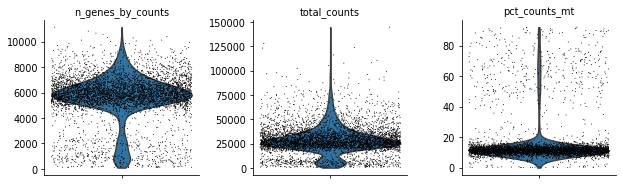

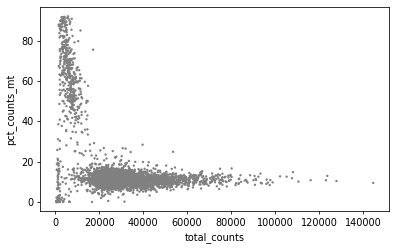

4110 samples pass the count filter
4374  samples pass the mt filter
Samples selected 3897


View of AnnData object with n_obs × n_vars = 3897 × 10001
    obs: 'TotalUMIs', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'log1p'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'spliced', 'unspliced'

In [4]:
# standard preprocessing
adata = adata_orig.copy()
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sv.pp.remove_duplicate_cells(adata)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
inds1 = np.where((adata.obs['total_counts']>15000) & (adata.obs['total_counts']<50000))
inds2 = np.where(adata.obs['pct_counts_mt']<15)
print(len(inds1[0]),'samples pass the count filter')
print(len(inds2[0]),' samples pass the mt filter')
ind_samples = np.intersect1d(inds1[0],inds2[0])
print('Samples selected',len(ind_samples))

adata = adata[ind_samples,:]

#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#             jitter=0.4, multi_panel=True)

sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=10001,n_bins=20)
ind_genes = np.where(adata.var['highly_variable'])[0]

adata = adata[:,ind_genes]


display(adata)

In [17]:
# pooling procedure
sc.tl.pca(adata,n_comps=50)
X_pca = adata.obsm['X_pca']

adata_work = adata_orig.copy()[ind_samples,:]
#display(adata_work)
adata = smooth_adata_by_pooling(adata_work,X_pca,n_neighbours=10)
#display(adata)
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=10000)
#display(adata)
sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata,n_top_genes=10001,n_bins=20)
#ind_genes = np.where(adata.var['highly_variable'])[0]
adata = adata[:,ind_genes]

sc.tl.pca(adata,n_comps=50)
X_pca = adata.obsm['X_pca']

In [5]:
sc.tl.pca(adata,n_comps=50)
X_pca = adata.obsm['X_pca']

... storing 'Aliases' as categorical
... storing 'CcdsID' as categorical
... storing 'Chromosome' as categorical
... storing 'ChromosomeEnd' as categorical
... storing 'CosmicID' as categorical
... storing 'DnaBindingDomain' as categorical
... storing 'FullName' as categorical
... storing 'GeneType' as categorical
... storing 'HgncID' as categorical
... storing 'IsTF' as categorical
... storing 'Location' as categorical
... storing 'LocationSortable' as categorical
... storing 'LocusGroup' as categorical
... storing 'LocusType' as categorical
... storing 'MgdID' as categorical
... storing 'MirBaseID' as categorical
... storing 'OmimID' as categorical
... storing 'PubmedID' as categorical
... storing 'RefseqID' as categorical
... storing 'RgdID' as categorical
... storing 'UcscID' as categorical
... storing 'UniprotID' as categorical
... storing 'VegaID' as categorical


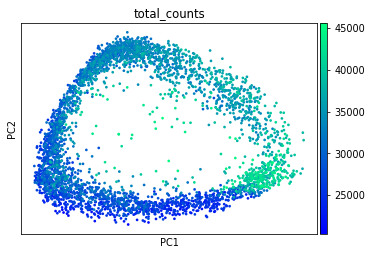

In [18]:
sc.pl.pca(adata,color='total_counts',cmap='winter')

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
50 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  3897  points and  50  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||30	8.949	30	30	30	0	0	0	8.1284	8.0058	0.7725	0.7759	0.5435	0.2771	8.3132	249.3966	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
3.511  seconds elapsed


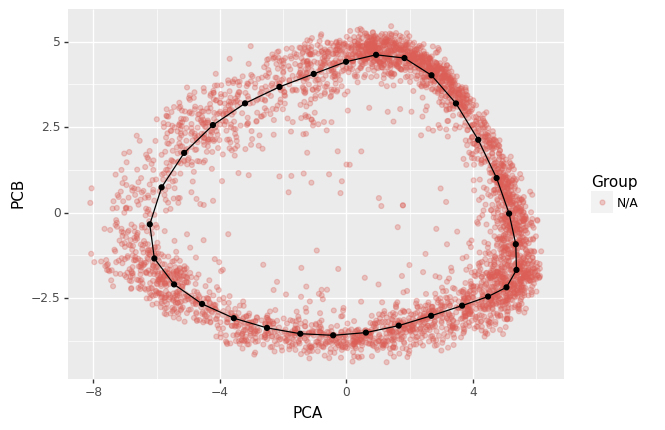

[<ggplot: (8734560203141)>]


In [19]:
import elpigraph
X_pca = X_pca.astype(np.float64)
#X_elpigraph_training = X_pca[:,0:2]
X_elpigraph_training = X_pca
egr = elpigraph.computeElasticPrincipalCircle(X_elpigraph_training,30)

(3897, 50)
3897
Suggested edge to remove 11
Selected edge to remove 11 [ 2 17]


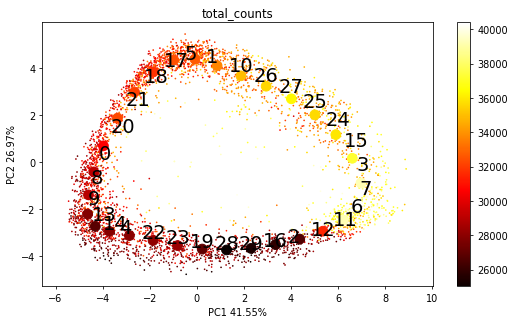

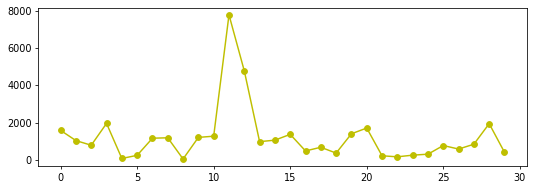

In [20]:
# here we detect the moment where the cell divides in two - 
# it will be zero for the pseudo-time

partition, dists = elpigraph.src.core.PartitionData(X = X_elpigraph_training, NodePositions = egr[0]['NodePositions'], MaxBlockSize = 100000000, TrimmingRadius = np.inf,SquaredX = np.sum(X_elpigraph_training**2,axis=1,keepdims=1))
ProjStruct = elpigraph.src.reporting.project_point_onto_graph(X = X_elpigraph_training,
                                     NodePositions = egr[0]['NodePositions'],
                                     Edges = egr[0]['Edges'][0],
                                     Partition = partition)

nodep = egr[0]['NodePositions']
edges = egr[0]['Edges'][0]

pca = PCA()
print(X_pca.shape)
mean_vector = np.mean(X_elpigraph_training)
u = pca.fit_transform(X_elpigraph_training)
v = pca.components_.T
s = pca.explained_variance_


nodep_pca = np.matmul(nodep-mean_vector,v)


total_counts = adata.obs['total_counts'].to_numpy()
print(len(total_counts))
node_read_counts = np.zeros(nodep.shape[0])
edge_abs_diff_counts = np.zeros(len(edges))
for i in range(len(nodep)):
    node_read_counts[i] = np.mean(total_counts[np.where(partition==i)[0]])
for i,e in enumerate(edges):
    edge_abs_diff_counts[i] = np.abs(node_read_counts[e[0]]-node_read_counts[e[1]])

plt.figure(figsize=(9,5))
plt.scatter(u[:,0],u[:,1],c=total_counts,s=0.5,cmap='hot')
plt.scatter(nodep_pca[:,0],nodep_pca[:,1],c=node_read_counts,s=100,cmap='hot')
#for i in range(len(nodep)):
#    plt.text(nodep_pca[i,0],nodep_pca[i,1],str(i),fontsize=20)
for i,e in enumerate(edges):
    mn_posx = np.mean(nodep_pca[e,0])
    mn_posy = np.mean(nodep_pca[e,1])
    plt.text(mn_posx,mn_posy,str(i),fontsize=20)

plt.axis('equal')
plt.colorbar()
plt.xlabel('PC1 {:.2f}%'.format(s[0]/np.sum(s)*100))
plt.ylabel('PC2 {:.2f}%'.format(s[1]/np.sum(s)*100))
plt.axis('equal')
plt.title('total_counts')
    
plt.figure(figsize=(9,3))
plt.plot(edge_abs_diff_counts,'yo-')

print('Suggested edge to remove',np.argmax(edge_abs_diff_counts))
edge_to_remove = np.argmax(edge_abs_diff_counts)
print('Selected edge to remove',edge_to_remove,edges[edge_to_remove])

17
[17, 3, 9, 21, 29, 15, 24, 26, 6, 11, 18, 7, 14, 1, 0, 25, 19, 22, 12, 8, 5, 16, 28, 23, 27, 20, 4, 10, 13, 2]


Text(0.5, 1.0, 'Total counts')

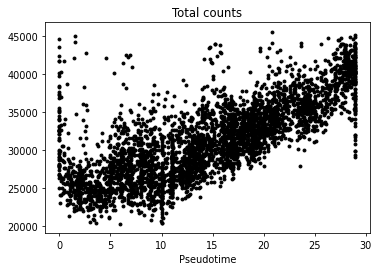

In [21]:
# Here we quantify the pseudo-time for further plotting

#import importlib
#importlib.reload(elpigraph_ps_tools)
from elpigraph_ps_tools import *

gr = egr[0].copy()
starting_node = edges[edge_to_remove,1]
print(starting_node)
edges = np.delete(gr['Edges'][0],edge_to_remove,axis=0)
w1 = np.delete(gr['Edges'][1],edge_to_remove,axis=0)
w2 = np.delete(gr['Edges'][2],edge_to_remove,axis=0)
gr['Edges'] = (edges,w1,w2)

traj = extract_trajectories(gr,starting_node,verbose=False)[0]
print(traj)

ProjStruct = project_on_tree(X_elpigraph_training,gr)
#pseudo_time_trajectory(traj,ProjStruct)
PseudoTimeTraj = quantify_pseudotime([traj],ProjStruct,producePlot=False)
points = PseudoTimeTraj[0]['Points'] 
pst = PseudoTimeTraj[0]['Pseudotime']

plt.plot(pst,total_counts[points],'k.')
plt.xlabel('Pseudotime')
plt.title('Total counts')

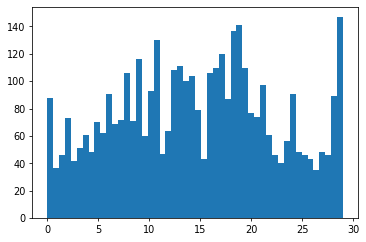

In [22]:
# Density of cells along the pseudotime

plt.hist(pst,bins=50)
plt.show()

In [29]:
# Estimating the local intrinsic dimensionality using several methods

n_neighbors = 200
adata.uns[f'lid{n_neighbors}']={}

s=time.time()
danco_caldata = skdim.gid.DANCo(D=50).fit(np.random.random((n_neighbors,50))).calibration_data_
adata.uns[f'lid{n_neighbors}']['DANCo'] = skdim.asPointwise(X_pca,skdim.gid.DANCo(D=50,calibration_data=danco_caldata), n_neighbors=n_neighbors)
print('DANCo',round(time.time()-s,2),'sec')
s=time.time()
adata.uns[f'lid{n_neighbors}']['ESS'] = skdim.asPointwise(X_pca,skdim.lid.ESS(),n_neighbors=n_neighbors)
print('ESS',round(time.time()-s,2))
s=time.time()
adata.uns[f'lid{n_neighbors}']['FisherS'] = skdim.asPointwise(X_pca,skdim.lid.FisherS(),n_neighbors=n_neighbors)
print('FisherS',round(time.time()-s,2))
s=time.time()
adata.uns[f'lid{n_neighbors}']['TwoNN'] = skdim.asPointwise(X_pca,skdim.gid.TwoNN(),n_neighbors=n_neighbors)
print('TwoNN',round(time.time()-s,2))
s=time.time()
adata.uns[f'lid{n_neighbors}']['alphaFO_0.1_PCA'] = skdim.asPointwise(X_pca,skdim.lid.lPCA(alphaFO=.1),n_neighbors=n_neighbors)
print('alphaFO_0.1_PCA',round(time.time()-s,2))
s=time.time()
adata.uns[f'lid{n_neighbors}']['alphaFO_0.05_PCA'] = skdim.asPointwise(X_pca,skdim.lid.lPCA(alphaFO=.05),n_neighbors=n_neighbors)
print('alphaFO_0.05_PCA',round(time.time()-s,2))



DANCo 110.31 sec
ESS 321.91
FisherS 19.33
TwoNN 7.65
alphaFO_0.1_PCA 11.32
alphaFO_0.05_PCA 13.95


<class 'numpy.ndarray'>


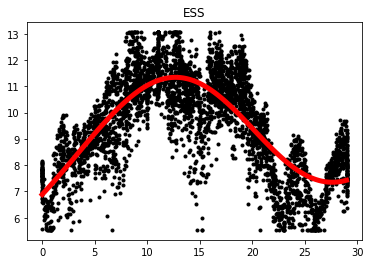

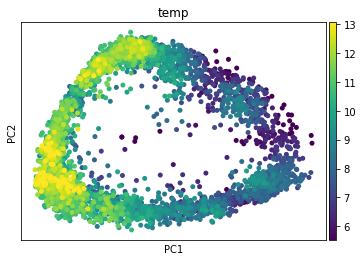

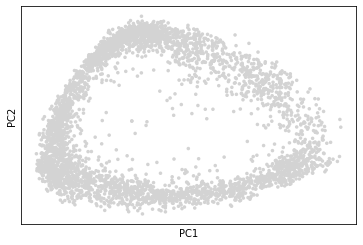

In [479]:
# Plotting the local intrinsic dimensionality computed using several methods

method = 'ESS'
#method = 'TwoNN'
#method = 'FisherS'
#method = 'DANCo'
#method = 'alphaFO_0.1_PCA'
#method = 'alphaFO_0.05_PCA'

print(type(points))

dims = np.array(adata.uns[f'lid{n_neighbors}'][method])
dims_ = dims[points]
ind_nonnan = np.argwhere(~np.isnan(dims_))
(x_smoothed,y_smothed) = kernel_regressor(pst[ind_nonnan].reshape(-1,1),dims_[ind_nonnan],alpha_factor=5)
dims = winsorize(dims, limits=(0.01,0.01), inclusive=(True, True), inplace=True)
dims_ = winsorize(dims_, limits=(0.01,0.01), inclusive=(True, True), inplace=True)
plt.plot(pst,dims_,'k.')
plt.plot(x_smoothed,y_smothed,'r-',linewidth=5)
plt.title(method)
adata.obs['temp'] = dims
sc.pl.pca(adata,color='temp',s=100,title=method)
sc.pl.pca(adata[np.argwhere(dims<25).transpose()[0],:],s=50)

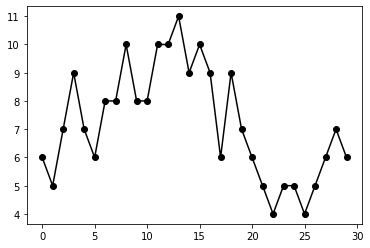

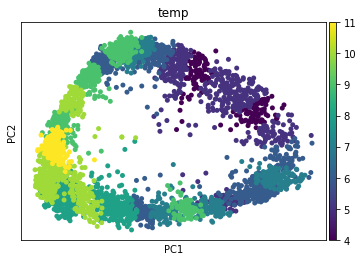

In [494]:
# Evaluate the dimensionality by graph node neighbourhoods
# Optionally, we can subsample each neighbourhoods to the same size (does not change much)

node_dims = np.zeros(len(traj))
point_dims = np.zeros(len(partition))
for i,n in enumerate(traj):
    inds = np.where(partition==n)[0]
    Xn = X_pca[inds,:]
    #res = skdim.lid.FisherS(conditional_number=10).fit(Xn)
    res = skdim.lid.ESS().fit(Xn)
    #res = skdim.gid.TwoNN().fit(Xn)
    res = skdim.lid.lPCA(alphaFO=.1).fit(Xn)
    #res = skdim.lid.lPCA(alphaFO=.05).fit(Xn)
    node_dims[i] = res.dimension_
    point_dims[inds] = res.dimension_

plt.plot(node_dims,'ko-')
adata.obs['temp'] = point_dims
sc.pl.pca(adata,color='Dimensionality',s=100)

Reduced dimension =  4
Graph is symmetric, only upper triangle of the separability matrix will be used


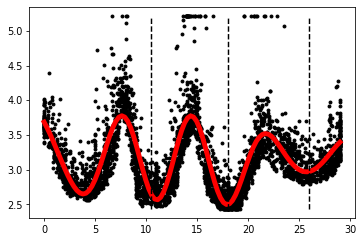

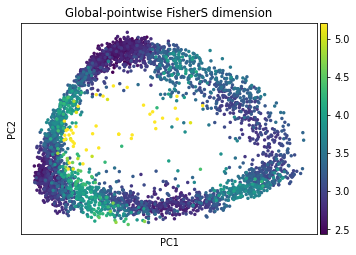

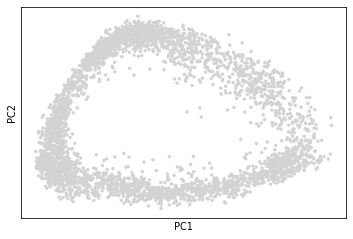

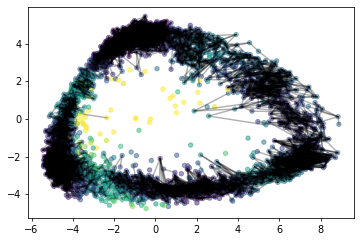

In [28]:
# global pointwise Fisher separability

np.save('X_pca.npy',X_pca)

fishers = skdim.lid.FisherS(conditional_number=10).fit(X_pca)
print('Reduced dimension = ',fishers.Xp_.shape[1])
glob_pw = fishers.point_inseparability_to_pointID(idx=15)[0]
edges,weights = fishers.getSeparabilityGraph()
ns = fishers.point_inseparability_to_pointID()[0]
nsw = winsorize(ns, limits=(0.01,0.01), inclusive=(True, True))
(x_smoothed,y_smothed) = kernel_regressor(pst.reshape(-1,1),glob_pw[points],alpha_factor=1)

glob_pw = winsorize(glob_pw, limits=(0.01,0.01), inclusive=(True, True), inplace=True)
plt.plot(pst,glob_pw[points],'k.')
plt.plot(x_smoothed,y_smothed,'r-',linewidth=5)

plt.plot([10.5,10.5],[np.min(glob_pw),np.max(glob_pw)],'k--')
plt.plot([18,18],[np.min(glob_pw),np.max(glob_pw)],'k--')
plt.plot([26,26],[np.min(glob_pw),np.max(glob_pw)],'k--')


adata.obs['Global pointwise FisherS'] = glob_pw
sc.pl.pca(adata,color='Global pointwise FisherS',s=50,title='Global-pointwise FisherS dimension')
sc.pl.pca(adata[np.argwhere(glob_pw<4).transpose()[0],:],s=50)

#edges
# xx = fishers.Xp_[:,0:2]
xx = X_pca[:,0:2]
plt.scatter(xx[:,0],xx[:,1],c=nsw,s=20,alpha=0.5)
fishers.plotSeparabilityGraph(xx[:,0],xx[:,1],edges)

In [45]:
# Code to compute the gene signatures from a gmt file

signature_dict = load_signature_file('/mnt/c/Datas/MOSAIC/expression/chromium_data/final/code/Y79_signatures.gmt')
sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata.var['highly_variable'])[0]
adata2k = adata[:,ind_genes2k]

scores_dic = calc_scores(adata2k,signature_dict)
scores_dic['HISTONES'] = calc_histone_score(adata2k)

Found histone genes: H3C13 H2BC19P H2AC20 H2AC21 H2AW H1-10 H2AC1 H2BC1 H3C2 H1-2 H4C3 H1-6 H2BC4 H2AC6 H1-4 H2BC5 H1-3 H4C9 H2AC12 H2AC14 H2BC15 H2AC16 H1-5 H19 H2AX H1-0


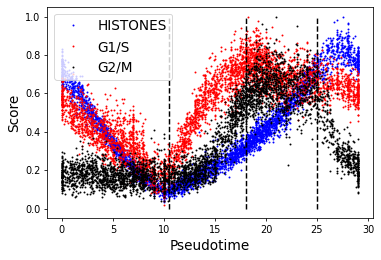

In [49]:
# Plot the cell cycle-related signatures

plt.plot(pst,scores_dic['G2PHASE_LATE'][points]/np.max(scores_dic['G2PHASE_LATE'][points]),'b.',markersize=2)
plt.plot(pst,scores_dic['SPHASE'][points]/np.max(scores_dic['SPHASE'][points]),'r.',markersize=2)
plt.plot(pst,scores_dic['HISTONES'][points]/np.max(scores_dic['HISTONES'][points]),'k.',markersize=2)
plt.legend(['HISTONES','G1/S','G2/M'],fontsize=14)
plt.xlabel('Pseudotime',fontsize=14)
plt.ylabel('Score',fontsize=14)

plt.plot([10.5,10.5],[0,1],'k--')
plt.plot([18,18],[0,1],'k--')
plt.plot([25,25],[0,1],'k--')
plt.show()

In [19]:
# Compute the RNA velocity

sv.pp.moments(adata)
sv.tl.velocity(adata, mode='stochastic')
sv.tl.velocity_graph(adata)


Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:17) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


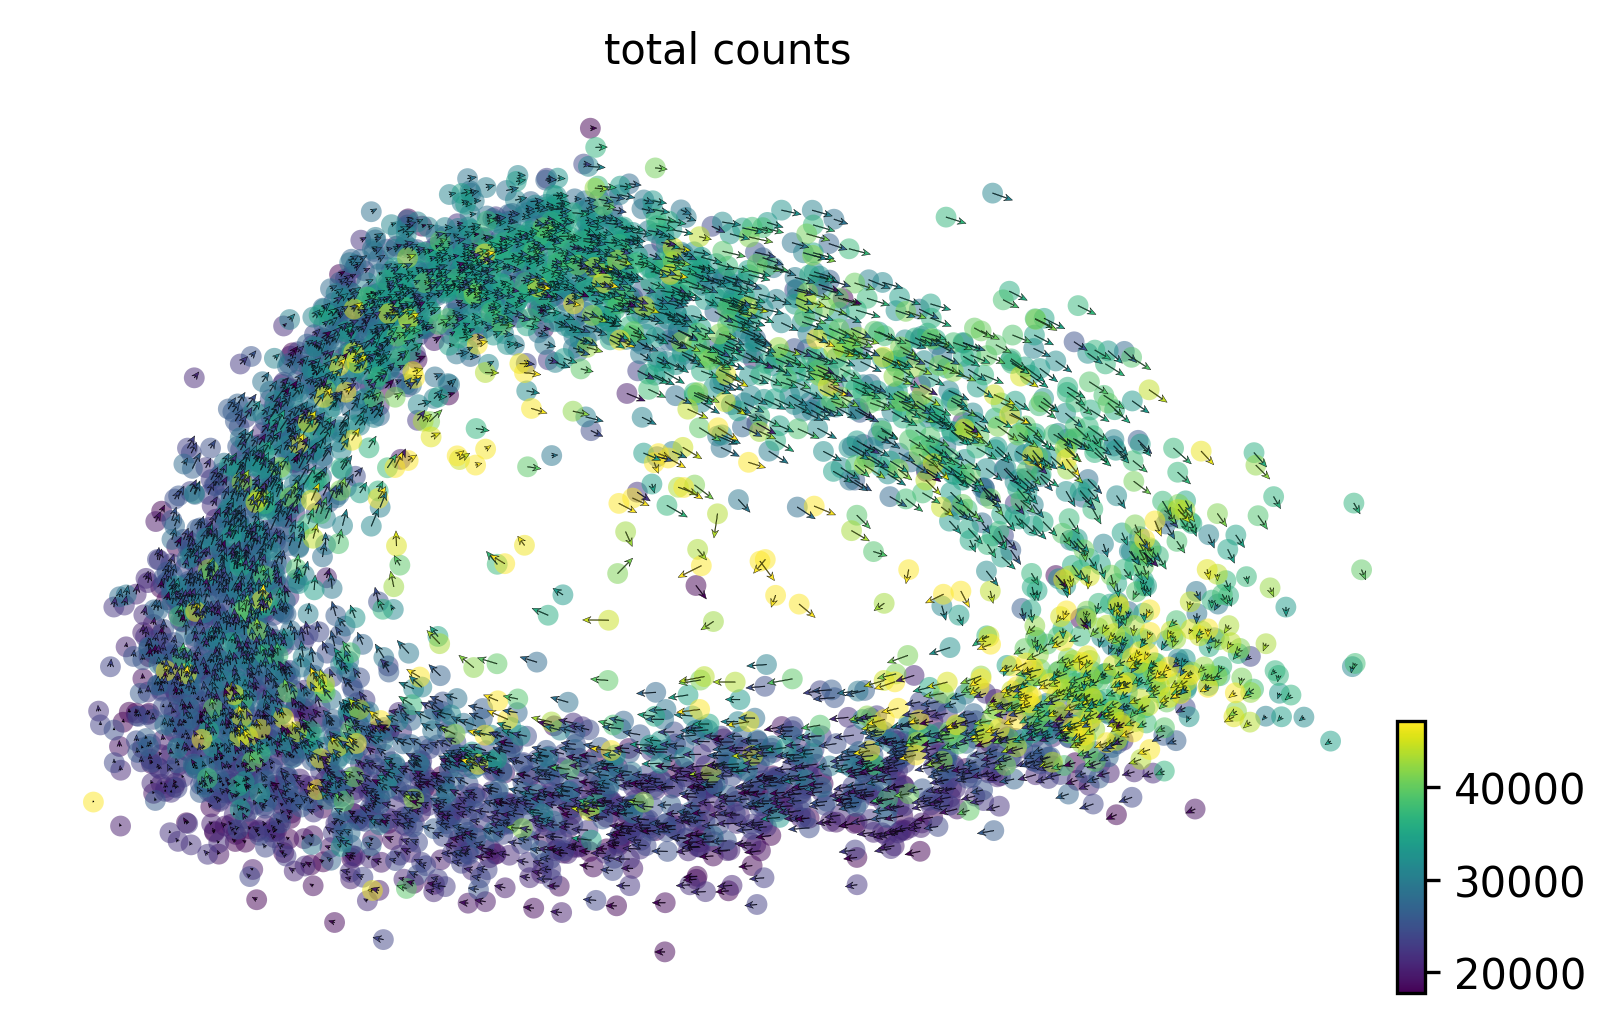

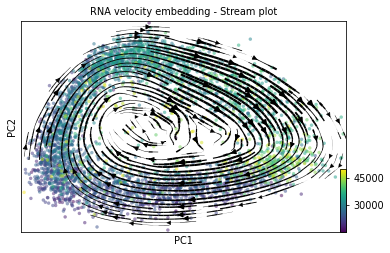

In [27]:
# Plot the RNA velocity

sv.pl.velocity_embedding(adata, basis='pca',components='1,2', color='total_counts', size=100, alpha=0.5,perc=[2,98],
                         arrow_size=1,dpi=300,arrow_length=5) 
#,alpha=0.5, legend_loc='on data', frameon=True, size=50,
#                         title='Y79 - RNA velocity embedding - Vector plot', xlabel='PC1', ylabel='PC2', legend_fontsize=14,
#                     linewidth=1.5,show=False, arrow_size=0)
sv.pl.velocity_embedding_stream(adata, basis='pca',components='1,2', color='total_counts',alpha=0.5, legend_loc='on data', frameon=True, size=50,
                         title='RNA velocity embedding - Stream plot', xlabel='PC1', ylabel='PC2', legend_fontsize=14,
                     linewidth=1.5,show=True)

In [28]:
# Reduce the dimensionality of the RNA velocity vectors

from sklearn.decomposition import PCA

velocity_X = adata.layers['velocity']
#velocity_X = adata.to_df().to_numpy()

print(velocity_X.shape)
pca = PCA(n_components=50)
u = pca.fit_transform(velocity_X)
v = pca.components_.T
s = pca.explained_variance_

velocity_PCA = u

(3897, 10001)


(3897, 50)


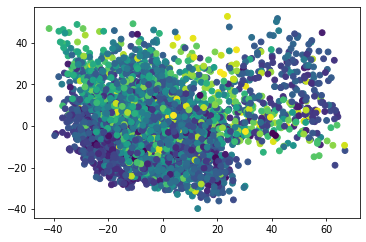

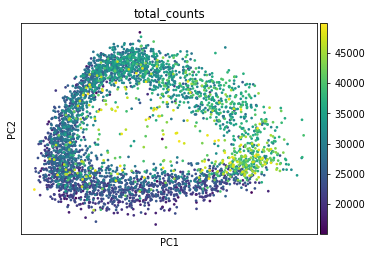

In [119]:
# Plot PCA for the RNA velocity vectors

print(u.shape)
plt.scatter(u[:,0],u[:,1],c=adata.obs['total_counts'])

In [493]:
# Compute the intrinsic dimensionality for RNA velocity vectors

n_neighbors = 200
adata.uns[f'velocity_lid{n_neighbors}']={}

s=time.time()
danco_caldata = skdim.gid.DANCo(D=50).fit(np.random.random((n_neighbors,50))).calibration_data_
adata.uns[f'velocity_lid{n_neighbors}']['DANCo'] = skdim.asPointwise(velocity_PCA,skdim.gid.DANCo(D=50,calibration_data=danco_caldata), n_neighbors=n_neighbors)
print('DANCo',round(time.time()-s,2),'sec')
s=time.time()
adata.uns[f'velocity_lid{n_neighbors}']['ESS'] = skdim.asPointwise(velocity_PCA,skdim.lid.ESS(),n_neighbors=n_neighbors)
print('ESS',round(time.time()-s,2))
s=time.time()
adata.uns[f'velocity_lid{n_neighbors}']['FisherS'] = skdim.asPointwise(velocity_PCA,skdim.lid.FisherS(),n_neighbors=n_neighbors)
print('FisherS',round(time.time()-s,2))
s=time.time()
adata.uns[f'velocity_lid{n_neighbors}']['TwoNN'] = skdim.asPointwise(velocity_PCA,skdim.gid.TwoNN(),n_neighbors=n_neighbors)
print('TwoNN',round(time.time()-s,2))
s=time.time()
adata.uns[f'velocity_lid{n_neighbors}']['alphaFO_0.1_PCA'] = skdim.asPointwise(velocity_PCA,skdim.lid.lPCA(alphaFO=.1),n_neighbors=n_neighbors)
print('alphaFO_0.1_PCA',round(time.time()-s,2))
s=time.time()
adata.uns[f'velocity_lid{n_neighbors}']['alphaFO_0.05_PCA'] = skdim.asPointwise(velocity_PCA,skdim.lid.lPCA(alphaFO=.05),n_neighbors=n_neighbors)
print('alphaFO_0.05_PCA',round(time.time()-s,2))


DANCo 143.59 sec
ESS 391.29
FisherS 16.09
TwoNN 11.19
alphaFO_0.1_PCA 8.8
alphaFO_0.05_PCA 8.75


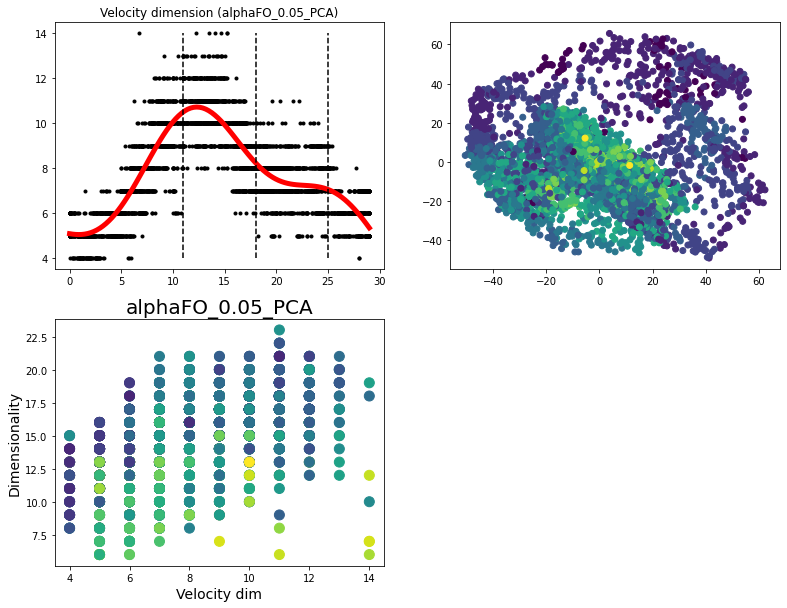

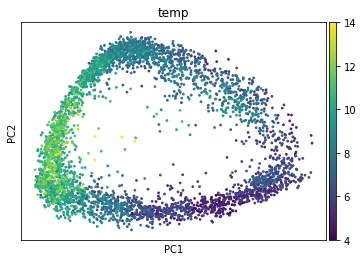

In [509]:
# Plot the intrinsic dimensionality for RNA velocity vectors

method = 'ESS'
#method = 'TwoNN'
method = 'FisherS'
#method = 'DANCo'
method = 'alphaFO_0.1_PCA'
method = 'alphaFO_0.05_PCA'

velocity_dims = np.array(adata.uns[f'velocity_lid{n_neighbors}'][method])
dims = np.array(adata.uns[f'lid{n_neighbors}'][method])

velocity_dims_ = velocity_dims[points]
ind_nonnan = np.argwhere(~np.isnan(velocity_dims_))
(x_smoothed,y_smothed) = kernel_regressor(pst[ind_nonnan].reshape(-1,1),velocity_dims_[ind_nonnan],alpha_factor=1)
velocity_dims = winsorize(velocity_dims, limits=(0.001,0.001), inclusive=(True, True), inplace=True)
velocity_dims_ = winsorize(velocity_dims_, limits=(0.001,0.001), inclusive=(True, True), inplace=True)

plt.figure(figsize=(13,10))
plt.subplot(221)
plt.plot(pst,velocity_dims_,'k.')
plt.plot(x_smoothed,y_smothed,'r-',linewidth=5)
plt.title('Velocity dimension ('+method+')')

plt.plot([11,11],[np.min(velocity_dims_),np.max(velocity_dims_)],'k--')
plt.plot([18,18],[np.min(velocity_dims_),np.max(velocity_dims_)],'k--')
plt.plot([25,25],[np.min(velocity_dims_),np.max(velocity_dims_)],'k--')

plt.subplot(222)
plt.scatter(velocity_PCA[:,0],velocity_PCA[:,1],c=velocity_dims)
plt.subplot(223)
plt.scatter(velocity_dims,dims,c=adata.obs['total_counts'],s=100)
plt.xlabel('Velocity dim',fontsize=14)
plt.ylabel('Dimensionality',fontsize=14)
plt.title(method,fontsize=20)
adata.obs['temp'] = velocity_dims
sc.pl.pca(adata,color='temp')

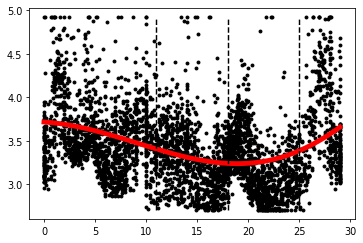

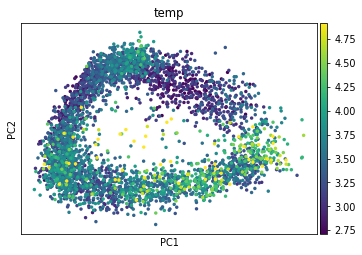

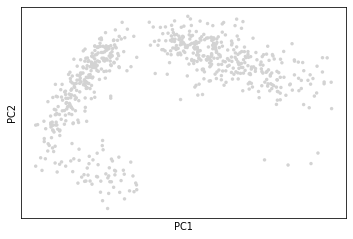

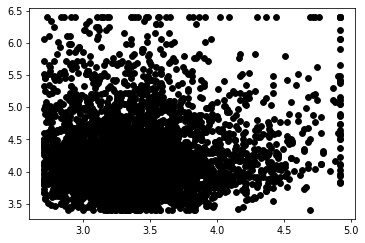

In [50]:
# global pointwise Fisher separability for velocity matrix

velocity_glob_pw = skdim.lid.FisherS(conditional_number=5).fit(velocity_PCA).point_inseparability_to_pointID()[0]
(x_smoothed,y_smothed) = kernel_regressor(pst.reshape(-1,1),velocity_glob_pw[points],alpha_factor=1)

velocity_glob_pw = winsorize(velocity_glob_pw, limits=(0.01,0.01), inclusive=(True, True), inplace=True)
plt.plot(pst,velocity_glob_pw[points],'k.')
plt.plot(x_smoothed,y_smothed,'r-',linewidth=5)

plt.plot([11,11],[np.min(velocity_glob_pw),np.max(velocity_glob_pw)],'k--')
plt.plot([18,18],[np.min(velocity_glob_pw),np.max(velocity_glob_pw)],'k--')
plt.plot([25,25],[np.min(velocity_glob_pw),np.max(velocity_glob_pw)],'k--')


adata.obs['temp'] = velocity_glob_pw
sc.pl.pca(adata,color='temp',s=50)
sc.pl.pca(adata[np.argwhere(velocity_glob_pw<3).transpose()[0],:],s=50)

plt.scatter(velocity_glob_pw,glob_pw,c='k')
plt.show()

In [29]:
# CytoTRACE analysis 

import time
from scipy.stats import gaussian_kde

%load_ext rpy2.ipython
%R source('/mnt/c/Libraries/CytoTRACE/R/CytoTRACE.R')

adata_cytotrace = adata_orig[ind_samples,ind_genes]
display(adata_cytotrace)
input_cyto=pd.DataFrame(adata_cytotrace.X.T)
#display(input_cyto)

s=time.time()
%R -i input_cyto
print('Loaded in ',round(time.time()-s,2),'sec')

cytotrace = %R cytotrace <- CytoTRACE(input_cyto)
cytotrace_score = np.array(cytotrace.rx2('CytoTRACE'))
cytotrace_genes = np.array(cytotrace.rx2('cytoGenes'))

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


View of AnnData object with n_obs × n_vars = 3897 × 10001
    obs: 'TotalUMIs'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'

,0,1,2,3,4,5,6,7,8,9,...,3887,3888,3889,3890,3891,3892,3893,3894,3895,3896
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,150.0,135.0,345.0,302.0,252.0,208.0,141.0,216.0,113.0,88.0,...,247.0,185.0,174.0,182.0,254.0,252.0,196.0,291.0,149.0,378.0
9997,52.0,43.0,98.0,65.0,63.0,100.0,64.0,82.0,29.0,31.0,...,76.0,87.0,54.0,68.0,65.0,90.0,74.0,87.0,56.0,115.0
9998,7.0,7.0,7.0,8.0,8.0,14.0,3.0,13.0,4.0,5.0,...,8.0,7.0,4.0,3.0,4.0,7.0,8.0,10.0,8.0,12.0
9999,16.0,12.0,13.0,18.0,17.0,24.0,10.0,20.0,12.0,6.0,...,16.0,9.0,12.0,9.0,21.0,29.0,23.0,26.0,5.0,46.0


R[write to console]: The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.



Loaded in  73.81 sec


R[write to console]: CytoTRACE will be run on 4 sub-sample(s) of approximately 974 cells each using 1 / 1 core(s)

R[write to console]: Pre-processing data and generating similarity matrix...

R[write to console]: Calculating gene counts signature...

R[write to console]: Smoothing values with NNLS regression and diffusion...

R[write to console]: Calculating genes associated with CytoTRACE...

R[write to console]: Done



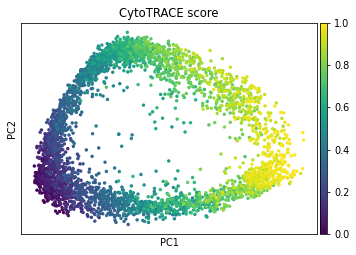

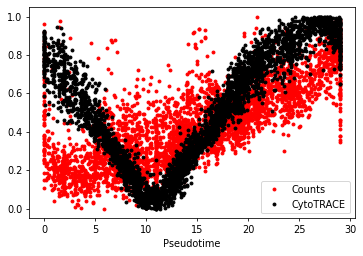

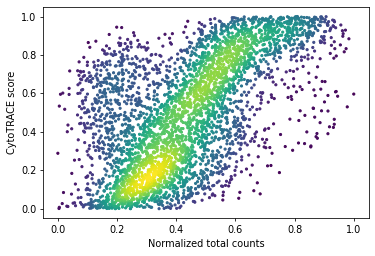

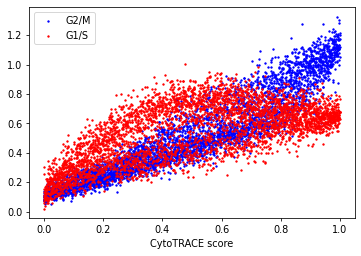

CytoTRACE genes: MALAT1 CDK1 AC027237.1 TOP2A KIFC1 TMPO MIS18BP1 ANLN NCAPG PRC1 MKI67 RAD21 AURKB NUSAP1 BUB1B SMC4 NCAPH XPO1 CDCA2 CKAP2 AURKA UBE2C RACGAP1 KNL1 HP1BP3 LMNB1 KIF2C AC091057.6 FAM83D TTK H2AX HSPA8 CENPF BUB3 SAFB SMC1A MT-ND2 DBF4 KIF18B CKS2 PIF1 RRM1 NUF2 PCM1 TACC3 NDC80 CDCA8 GTSE1 ECT2 CDCA3 CENPA KIF22 INCENP HMGB2 UBE2T HJURP PLK1 DEPDC1 PCLAF TYMS SKA3 SGO1 HNRNPU NSD2 CDC27 ZWINT DEK TAF15 KIF18A KPNA2 KIF11 KNSTRN FOXM1 ZMYM1 ARHGEF39 STIL MT-ND1 TPX2 CDKN2C DIAPH3 SPAG5 MAD2L1 ARHGAP11A NEAT1 KIF20B MELK SPC24 LBR ASPM MT-ND5 MXD3 RRM2 BRCA1 NCL MT-ND3 ANP32E NRDC KIF15 RPS18 SMC2 CENPE H4C3 CENPL DUT FANCI ZC3H13 PNRC2 TMPO-AS1 ATAD2 CDK5RAP2 CKAP5 PBK KIF20A G2E3 MATR3-1 CEP350 CCND1 HNRNPA3P4 CKAP2L BUB1 USP1 KIF14 SAMD1 RHNO1 CEP55 MT-ND4L MYBL2 CDCA5 TUBB4B CDC25C H1-4 KTN1 ESPL1 SPDL1 H1-5 SGO2 SPC25 HMGB1 BRD8 H1-10 HSPA1A RPL11 NFIA NCAPD2 MND1 ADD3 PSRC1 TPM3 HOOK1 PTPN13 NEK2 GAS2L3 H3-3B DEPDC1B H1-2 ID3 TMEM106C HNRNPDL HMMR ZNF638 RPL8 EPB41

In [172]:
# Plot the results of the CytoTRACE analysis 

adata.obs['temp'] = cytotrace_score
sc.pl.pca(adata,color='temp',s=50,title='CytoTRACE score')
normalized_total_counts = (adata.obs['total_counts']-np.min(adata.obs['total_counts']))/(np.max(adata.obs['total_counts'])-np.min(adata.obs['total_counts']))
plt.plot(pst,normalized_total_counts[points],'r.')
plt.plot(pst,cytotrace_score[points],'k.')
plt.xlabel('Pseudotime')
plt.legend(['Counts','CytoTRACE'])
plt.show()

x = normalized_total_counts
y = cytotrace_score
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(normalized_total_counts,cytotrace_score,s=5,c=z)
plt.xlabel('Normalized total counts')
plt.ylabel('CytoTRACE score')
plt.show()


plt.scatter(cytotrace_score,scores_dic['G2PHASE_LATE'],c='b',s=2)
plt.scatter(cytotrace_score,scores_dic['SPHASE'],c='r',s=2)
plt.legend(['G2/M','G1/S'])
#plt.xlabel('G2/M score')
plt.xlabel('CytoTRACE score')
plt.show()

gcsGenesNames = %R names(cytotrace$gcsGenes)
gene_inds = [int(s) for s in gcsGenesNames]
cytoscape_gene_names = adata.var_names[np.array(gene_inds)][0:200]
print('CytoTRACE genes:',*cytoscape_gene_names)

In [175]:
#score = cytotrace_score
score = glob_pw
#score = adata.obs['total_counts']

(signature_gene_names_positive,signature_scores_positive,_,_) = get_surrogate_signature(adata,score)
(signature_gene_names_negative,signature_scores_negative,_,_) = get_surrogate_signature(adata,score,negative_side=True)

print('Positive signature genes:',*signature_gene_names_positive)
print('Negative signature genes:',*signature_gene_names_negative)

Positive signature genes: GAS1 RREB1 SLCO5A1 SKA2 HSP90AA1 MEIS1 PTTG1 JPT1 HNRNPH3 UBC ODC1 CEBPB RBMX PTGER3 ANKRD42 BARHL2 CDC20 HSP90B1 TUBA1C NUCKS1P1 ANP32E REEP3 CDKN3 LMNA MYEF2 ARL6IP1 DYNLL1 EMC9 FBXO32 CEP41 PRCP HAND2 CERCAM FH C1orf56 HSPH1 SAP30 HMGB1 ODF2 EFNB1 KPNA2 GRK5 RAMP2-AS1 CCNB1 TROAP SLC24A5 PRR11 CCNB2 AHNAK BIRC5 GYG2 ATP1A1 CDC25B NUDT4 CITED2 GDF6 AC079142.1 AP000873.1 GIHCG FAM216A TWIST1 CNIH4 DARS2 KLF6 EPB41L2 DYNC1H1 UBE2S LCP1 AL356095.2 MEIOB SLC7A5 AC239811.1 DLGAP5 KTN1 ATP8B3 SPTBN1 ZEB2 CPEB2 BNC2 RUNX3 PIK3R1 ELMSAN1 ANKRD6 FSTL1 AKAP7 PRELID2 TDRD3 AC090192.1 CKAP5 DDIAS SLC9A3R2 SOX2 SPA17 NR4A3 DLX3 FNBP4 CDK5RAP2 ATP11C ZSWIM6 GFRA2
Negative signature genes: AL035456.1 BTG3 DPF1 PLEKHA1 H2AC16 CCP110 H2AC17 ZNF672 SLBP NAPB BRD2 ID3 SFI1 AC092634.3 MCM3 UCK1 PNP PCNA NRTN USP49 C21orf91 RABAC1 FTL AC015818.2 STXBP6 NRSN2 RPS18 TEX264 B4GALNT1 RFC4 IMPA2 RASSF5 ADCK2 OAF FEN1 PLEKHH3 SEC13P1 FANCA MCM5 LINC00463 POLD3 TSEN54 FAM111B LIMK2 HEL

SpearmanrResult(correlation=0.3974741425091711, pvalue=1.1652687808099889e-147) (positive)
SpearmanrResult(correlation=-0.287369933002618, pvalue=5.587292251438503e-75) (negative)


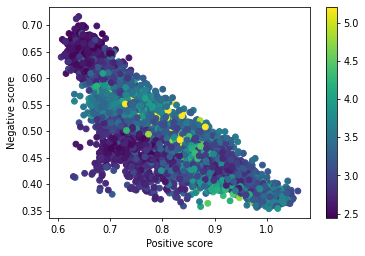

In [176]:
print(stats.spearmanr(score,signature_scores_positive),'(positive)')
print(stats.spearmanr(score,signature_scores_negative),'(negative)')
plt.scatter(signature_scores_positive,signature_scores_negative,c=score)
plt.xlabel('Positive score')
plt.ylabel('Negative score')
plt.colorbar()
plt.show()